## Exercício
Um dataset sintético contendo alguns exemplos de diferentes formas básicas é criado. Em seguida, crie um dataset e um modelo convolucional que classifique o formato na imagem.

In [ ]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Parâmetros
image_size = 64
num_examples = 2000
num_classes = 5
output_file = "data/synthetic.csv"

In [ ]:
# Função para gerar uma imagem de uma determinada classe
def generate_image(label):
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    if label == 0:
        # Classe 0: Círculos
        center = (np.random.randint(10, image_size-10), np.random.randint(10, image_size-10))
        radius = np.random.randint(5, 10)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.circle(image, center, radius, color, -1)
    elif label == 1:
        # Classe 1: Triângulos equiláteros
        side_length = np.random.randint(10, 20)
        height = int(np.sqrt(3)/2 * side_length)
        center = (np.random.randint(side_length//2, image_size-side_length//2),
                  np.random.randint(height//2, image_size-height//2))
        pts = np.array([[center[0], center[1] - 2*height//3],
                        [center[0] - side_length//2, center[1] + height//3],
                        [center[0] + side_length//2, center[1] + height//3]], np.int32)
        pts = pts.reshape((-1, 1, 2))
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.fillPoly(image, [pts], color)
    elif label == 2:
        # Classe 2: Linhas Horizontais
        y = np.random.randint(5, image_size-5)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        thickness = np.random.randint(1, 3)
        cv2.line(image, (0, y), (image_size, y), color, thickness)
    elif label == 3:
        # Classe 3: Quadrados
        top_left = (np.random.randint(10, image_size-10), np.random.randint(10, image_size-10))
        size = np.random.randint(5, 10)
        bottom_right = (top_left[0] + size, top_left[1] + size)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.rectangle(image, top_left, bottom_right, color, -1)
    elif label == 4:
        # Classe 4: Linhas Verticais
        x = np.random.randint(5, image_size-5)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        thickness = np.random.randint(1, 3)
        cv2.line(image, (x, 0), (x, image_size), color, thickness)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [ ]:
def show_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

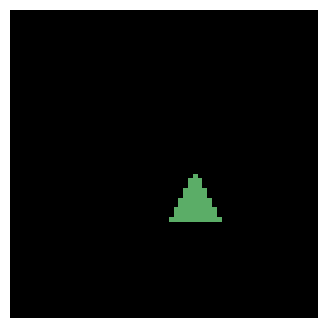

In [ ]:
show_image(generate_image(1))

In [ ]:
!mkdir -p data

In [ ]:
data = []
labels = []
for _ in tqdm(range(num_examples)):
    label = np.random.randint(0, num_classes)
    image = generate_image(label).flatten()
    data.append(np.concatenate(([label], image)))
    labels.append(label)

data = np.array(data)

# Salvando em CSV
df = pd.DataFrame(data)
df.to_csv(output_file, index=False, header=False)

print(f"Dataset salvo em {output_file}")

100%|██████████| 2000/2000 [00:00<00:00, 18119.08it/s]


Dataset salvo em data/synthetic.csv


## Agora é com você!

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Definição da classe SyntheticCSVLoader para carregar o dataset a partir de um arquivo CSV. Baseie-se no MNISTDataset do notebook "04 - Basic CNNs.ipynb"
class SyntheticCSVLoader(Dataset):
    def __init__(self, csv_file, image_size=64, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]

        # As demais colunas são os pixels da imagem (64x64x3)
        image = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape(self.image_size, self.image_size, 3)

        # Converte a imagem para tensor e ajusta os eixos para o formato (C, H, W)
        image = torch.tensor(image).permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

synthetic_dataset = SyntheticCSVLoader(
    csv_file="data/synthetic.csv",
    transform=transform
)

In [ ]:
image,label = synthetic_dataset[0]

In [ ]:
image

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])

In [ ]:
label

3

In [ ]:
# Dividindo o dataset em conjuntos de treino e teste

trainset = Subset(synthetic_dataset, range(0, int(0.8 * len(synthetic_dataset))))
testset = Subset(synthetic_dataset, range(int(0.8 * len(synthetic_dataset)), len(synthetic_dataset)))

In [ ]:
# Criando DataLoaders para os subsets

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.conv3 = nn.Conv2d(12, 24, 5)
        self.fc1 = nn.Linear(24 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x,2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x,2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x,2)

        x = x.view(-1, 24 * 4 * 4)
        x = F.relu(self.fc1(x))

        x = F.dropout(x, training=self.training)

        x = self.fc2(x)

        return x

model = CNN()

images, labels = next(iter(trainloader))

model(images).shape

torch.Size([32, 5])

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Treinamento
history = train_model(model, trainloader, testloader, criterion, optimizer, num_epochs=20)

100%|██████████| 50/50 [00:04<00:00, 12.13it/s]


Epoch 1, Train Loss: 1.608, Train Accuracy: 20.88%
Epoch 1, Val Loss: 1.609, Val Accuracy: 17.75%


100%|██████████| 50/50 [00:03<00:00, 16.14it/s]


Epoch 2, Train Loss: 1.606, Train Accuracy: 21.94%
Epoch 2, Val Loss: 1.611, Val Accuracy: 17.75%


100%|██████████| 50/50 [00:03<00:00, 16.39it/s]


Epoch 3, Train Loss: 1.605, Train Accuracy: 21.88%
Epoch 3, Val Loss: 1.607, Val Accuracy: 17.75%


100%|██████████| 50/50 [00:03<00:00, 14.15it/s]


Epoch 4, Train Loss: 1.596, Train Accuracy: 21.81%
Epoch 4, Val Loss: 1.585, Val Accuracy: 17.75%


100%|██████████| 50/50 [00:03<00:00, 14.44it/s]


Epoch 5, Train Loss: 1.536, Train Accuracy: 26.69%
Epoch 5, Val Loss: 1.403, Val Accuracy: 34.50%


100%|██████████| 50/50 [00:03<00:00, 16.42it/s]


Epoch 6, Train Loss: 1.497, Train Accuracy: 35.50%
Epoch 6, Val Loss: 1.555, Val Accuracy: 28.25%


100%|██████████| 50/50 [00:03<00:00, 16.34it/s]


Epoch 7, Train Loss: 1.548, Train Accuracy: 28.44%
Epoch 7, Val Loss: 1.482, Val Accuracy: 43.50%


100%|██████████| 50/50 [00:04<00:00, 12.35it/s]


Epoch 8, Train Loss: 1.391, Train Accuracy: 48.38%
Epoch 8, Val Loss: 1.108, Val Accuracy: 58.50%


100%|██████████| 50/50 [00:03<00:00, 16.40it/s]


Epoch 9, Train Loss: 1.400, Train Accuracy: 36.12%
Epoch 9, Val Loss: 1.390, Val Accuracy: 34.75%


100%|██████████| 50/50 [00:03<00:00, 16.08it/s]


Epoch 10, Train Loss: 1.384, Train Accuracy: 38.62%
Epoch 10, Val Loss: 1.617, Val Accuracy: 32.50%


100%|██████████| 50/50 [00:03<00:00, 13.24it/s]


Epoch 11, Train Loss: 1.420, Train Accuracy: 34.56%
Epoch 11, Val Loss: 1.323, Val Accuracy: 41.25%


100%|██████████| 50/50 [00:03<00:00, 15.14it/s]


Epoch 12, Train Loss: 1.333, Train Accuracy: 37.75%
Epoch 12, Val Loss: 1.267, Val Accuracy: 43.00%


100%|██████████| 50/50 [00:03<00:00, 16.40it/s]


Epoch 13, Train Loss: 1.282, Train Accuracy: 40.69%
Epoch 13, Val Loss: 1.233, Val Accuracy: 48.00%


100%|██████████| 50/50 [00:03<00:00, 16.51it/s]


Epoch 14, Train Loss: 1.177, Train Accuracy: 52.38%
Epoch 14, Val Loss: 1.110, Val Accuracy: 58.75%


100%|██████████| 50/50 [00:03<00:00, 12.53it/s]


Epoch 15, Train Loss: 1.058, Train Accuracy: 58.50%
Epoch 15, Val Loss: 0.955, Val Accuracy: 68.00%


100%|██████████| 50/50 [00:03<00:00, 16.44it/s]


Epoch 16, Train Loss: 0.821, Train Accuracy: 66.12%
Epoch 16, Val Loss: 0.629, Val Accuracy: 77.75%


100%|██████████| 50/50 [00:03<00:00, 16.18it/s]


Epoch 17, Train Loss: 0.669, Train Accuracy: 71.25%
Epoch 17, Val Loss: 0.621, Val Accuracy: 72.50%


100%|██████████| 50/50 [00:03<00:00, 13.19it/s]


Epoch 18, Train Loss: 0.683, Train Accuracy: 69.56%
Epoch 18, Val Loss: 0.567, Val Accuracy: 74.25%


100%|██████████| 50/50 [00:03<00:00, 15.35it/s]


Epoch 19, Train Loss: 0.568, Train Accuracy: 75.50%
Epoch 19, Val Loss: 0.426, Val Accuracy: 83.00%


100%|██████████| 50/50 [00:03<00:00, 16.13it/s]


Epoch 20, Train Loss: 0.740, Train Accuracy: 71.00%
Epoch 20, Val Loss: 0.828, Val Accuracy: 70.00%
Treinamento concluído


In [ ]:
# Teste
test_model(model, testloader)

Acurácia da rede na base de teste: 84.00%


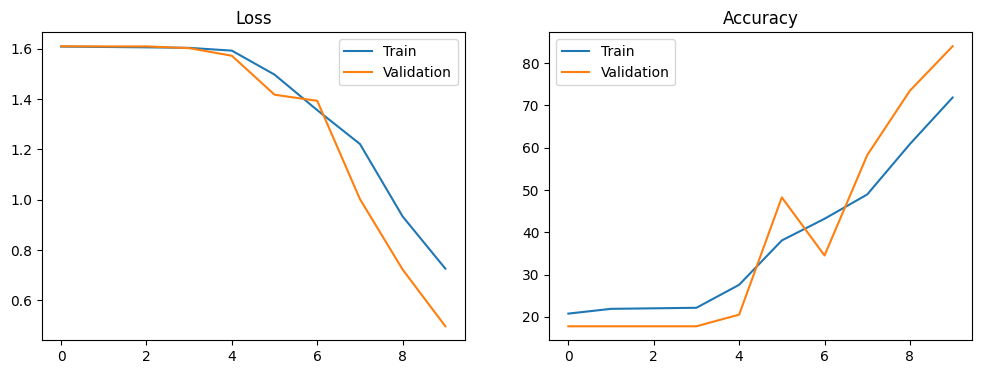

In [ ]:
plot_history(history)